In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import pandas as pd
from pandas_datareader import data 
import matplotlib.pyplot as plt

sns.set(style='darkgrid', context='talk', palette='Dark2')

Example of web scrapping on Microsoft

In [121]:
from datetime import date

today = date.today()
d1 = today.strftime("%Y-%m-%d")

In [122]:
d1 = today.strftime("%Y-%m-%d")

In [123]:
d1

'2022-11-03'

In [124]:
start_date = '2000-01-01'
end_date = '2022-10-31'
microsoft = data.DataReader('MSFT', 'yahoo', start_date, d1)
microsoft

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,59.312500,56.000000,58.687500,58.281250,53228400.0,36.555378
2000-01-04,58.562500,56.125000,56.781250,56.312500,54119000.0,35.320522
2000-01-05,58.187500,54.687500,55.562500,56.906250,64059600.0,35.692936
2000-01-06,56.937500,54.187500,56.093750,55.000000,54976600.0,34.497299
2000-01-07,56.125000,53.656250,54.312500,55.718750,62013600.0,34.948109
...,...,...,...,...,...,...
2022-10-28,236.600006,226.050003,226.240005,235.869995,40647700.0,235.869995
2022-10-31,234.919998,231.149994,233.759995,232.130005,28357300.0,232.130005
2022-11-01,235.740005,227.330002,234.600006,228.169998,30592300.0,228.169998


Having imported the appropriate tools, getting market data from a free online source, such as Yahoo Finance, is super easy. Since pandas has a simple remote data access for the Yahoo Finance API data, this is as simple as:

In [125]:
def web_scrapper():

    from datetime import date

    today = date.today()
    end_date = today.strftime("%Y-%m-%d")

    tickers = pd.read_csv("CSV/constituents.csv")
    tickers_symbol = tickers['Symbol']

    # Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
    # tickers = ['AAPL', 'MSFT', 'GOOG', 'META']

    # We would like all available data from 01/01/2000 until 2022-10-31.
    start_date = '2000-01-01'
    end_date = '2022-10-31'

    # User pandas_reader.data.DataReader to load the desired data.
    df = data.DataReader(tickers_symbol, 'yahoo', start_date, end_date) # I commented this line because I saved the scrapped data into a .csv
    microsoft = data.DataReader('MSFT', 'yahoo', start_date, end_date)
    close = df['Close']
    volume = df['Volume']

    #Let us assume we are interested in working with the Close prices which have been already been adjusted by Yahoo finance to account for stock splits. We want to make sure that all weekdays are included in our dataset, which is very often desirable for quantitative trading strategies.

    #Of course, some of the weekdays might be public holidays in which case no price will be available. For this reason, we will fill the missing prices with the latest available prices:

    all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')  # B stands for business day frequency
    close = close.reindex(all_weekdays)
    close = close.fillna(method='ffill')
    # close.set_index(microsoft.index)    
    volume = volume.reindex(all_weekdays)
    volume = volume.fillna(method='ffill')
    # volume.set_index(microsoft.index)   
    df = df.reindex(all_weekdays)
    df = df.fillna(method='ffill')  

    # df.to_csv("CSV/sp500.csv",index=False)
    # close.to_csv("CSV/sp500-close.csv",index=False)
    # volume.to_csv("CSV/sp500-volume.csv", index=False)

    df.to_csv("CSV/sp5002.csv",index=False)
    close.to_csv("CSV/sp5002-close.csv",index=False)
    volume.to_csv("CSV/sp5002-volume.csv", index=False)

    return df, close, volume


In [126]:
# web_scrapper()

In [127]:
sp500 = pd.read_csv("CSV/sp5002.csv")
close = pd.read_csv("CSV/sp5002-close.csv")
volume = pd.read_csv("CSV/sp5002-volume.csv")

/home/joaodocarglass/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,2

#### Preparing the Data

Let us assume we are interested in working with the Close prices which have been already been adjusted by Yahoo finance to account for stock splits. We want to make sure that all weekdays are included in our dataset, which is very often desirable for quantitative trading strategies.

Of course, some of the weekdays might be public holidays in which case no price will be available. For this reason, we will fill the missing prices with the latest available prices:

Let's build a function to drop columns with nulls percentage above 25

In [128]:
def drop_null_columns(data):
    nulls_percent_df = pd.DataFrame(data.isna().sum()/len(data)).reset_index()
    nulls_percent_df.columns = ['column_name', 'nulls_percentage']
    # nulls_percent_df.head()
    columns_above_threshold = nulls_percent_df[nulls_percent_df['nulls_percentage']>0]
    # print(len(columns_above_threshold['column_name']))
    drop_columns_list = list(columns_above_threshold['column_name'])
    # print(drop_columns_list)
    data = data.drop(columns=drop_columns_list)
    data.shape
    return data

In [129]:
close.isna().sum()

MMM        0
AOS        0
ABT        0
ABBV    3392
ABMD       0
        ... 
KSU     5956
PBCT    5956
VIAC    5956
WLTW    5956
XLNX    5956
Length: 505, dtype: int64

In [130]:
close = drop_null_columns(close)

In [131]:
volume = drop_null_columns(volume)

In [132]:
close.isna().sum()

MMM     0
AOS     0
ABT     0
ABMD    0
ATVI    0
       ..
WMB     0
XEL     0
YUM     0
ZBRA    0
ZION    0
Length: 364, dtype: int64

#### Now we are going to create 100 random portfolios for the close and the volume
#### Each sample will be of 5 samples from the whole population

In [133]:
close

,MMM,AOS,ABT,ABMD,ATVI,ADM,ADBE,AMD,AES,AFL,...,WELL,WST,WDC,WY,WHR,WMB,XEL,YUM,ZBRA,ZION
0,47.187500,3.614583,15.711531,18.250000,1.369792,10.884354,16.390625,15.500000,36.250000,11.187500,...,15.375000,7.562500,3.937500,69.875000,61.812500,23.198961,19.000000,6.706057,25.027779,55.500000
1,45.312500,3.562500,15.262630,17.812500,1.328125,10.770975,15.015625,14.625000,34.812500,10.890625,...,15.312500,7.640625,4.687500,67.250000,59.437500,22.684469,19.437500,6.571262,24.666668,52.812500
2,46.625000,3.552083,15.234574,18.000000,1.333333,10.600907,15.312500,15.000000,35.187500,10.828125,...,15.750000,7.609375,4.375000,70.812500,60.312500,24.087631,20.187500,6.604960,25.138889,52.750000
3,50.375000,3.500000,15.767643,18.031250,1.307292,10.657596,15.437500,16.000000,35.468750,11.046875,...,16.562500,7.531250,4.562500,74.125000,60.812500,24.602125,20.000000,6.548796,23.777779,53.500000
4,51.375000,3.645833,15.935981,17.937500,1.343750,10.827664,16.187500,16.250000,36.156250,11.265625,...,16.812500,7.609375,5.625000,71.687500,61.000000,25.256933,20.000000,6.402768,23.513889,53.625000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5951,118.500000,52.099998,97.949997,264.290009,72.500000,91.139999,323.790009,61.470001,25.190001,61.950001,...,60.360001,249.210007,35.290001,30.910000,137.000000,31.850000,62.400002,111.239998,274.579987,51.509998
5952,122.699997,51.950001,98.419998,268.250000,72.480003,93.589996,320.480011,59.730000,25.450001,61.959999,...,60.400002,254.399994,35.279999,30.959999,134.740005,32.150002,62.570000,112.269997,273.179993,50.400002
5953,122.800003,51.900002,96.930000,267.579987,72.500000,94.129997,318.649994,58.599998,25.770000,62.700001,...,59.939999,221.229996,34.340000,31.010000,135.029999,32.500000,63.250000,113.910004,275.290009,50.380001
5954,126.599998,54.380001,99.489998,258.059998,72.849998,94.879997,325.679993,62.009998,26.459999,64.790001,...,61.500000,225.509995,35.500000,31.100000,139.910004,32.669998,65.370003,117.879997,288.000000,51.540001


In [134]:
all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')  # B stands for business day frequency

microsoft = microsoft.reindex(all_weekdays)
microsoft = microsoft.fillna(method='ffill')

In [135]:
microsoft.index

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2022-10-18', '2022-10-19', '2022-10-20', '2022-10-21',
               '2022-10-24', '2022-10-25', '2022-10-26', '2022-10-27',
               '2022-10-28', '2022-10-31'],
              dtype='datetime64[ns]', length=5956, freq='B')

In [136]:
close.set_index(microsoft.index, inplace=True)
volume.set_index(microsoft.index, inplace=True)

In [137]:
def random_portfolios(data):
    import random
    list_of_portfolios = []
    tickers_data = list(data.columns.values)
    for i in range(10000):
        portofolio_aleatorio = random.sample(tickers_data, 5)
        list_of_portfolios.append(data[portofolio_aleatorio])
    return list_of_portfolios

In [138]:
list_of_portfolios_close = random_portfolios(close)

In [139]:
list_of_portfolios_volume = random_portfolios(volume)

In [140]:
list_of_portfolios_close[0]

,SWKS,BIIB,PFE,UDR,CMI
2000-01-03,31.406250,31.083332,30.241936,9.937500,11.828125
2000-01-04,29.562500,28.979168,29.115274,9.500000,11.500000
2000-01-05,30.328125,31.000000,29.589659,9.687500,11.515625
2000-01-06,27.375000,32.375000,30.657021,10.375000,11.921875
2000-01-07,30.187500,36.104168,32.732449,10.187500,12.234375
...,...,...,...,...,...
2022-10-25,86.680000,273.559998,45.590000,40.570000,234.679993
2022-10-26,85.639999,280.429993,46.060001,39.529999,236.970001
2022-10-27,83.839996,277.869995,45.740002,39.270000,238.929993
2022-10-28,88.059998,284.290009,47.430000,39.580002,244.779999


In [141]:
best_portfolio_values = [0]
best_portfolio = []
for x in range(10000):
    stock_performance = []
    for i in list_of_portfolios_close[x]:
        stock_performance.append(list_of_portfolios_close[x][i][-1:].values[0] - list_of_portfolios_close[x][i][0:].values[0])
    
    if np.mean(best_portfolio_values) < np.mean(stock_performance):
        best_portfolio_values = stock_performance
        best_portfolio = list_of_portfolios_close[x].columns


best_portfolio_values, best_portfolio

([16.131248474121087,
  4191.1875,
  37.68106842041015,
  374.3825073242188,
  2502.3173828125],
 Index(['MU', 'NVR', 'BAX', 'DE', 'AZO'], dtype='object'))

In [142]:
best = pd.DataFrame(best_portfolio_values, best_portfolio).T
best

,MU,NVR,BAX,DE,AZO
0,16.131248,4191.1875,37.681068,374.382507,2502.317383


In [143]:
# stock_performance = list_of_portfolios[0]['GLW'][-1:].values[0] - list_of_portfolios[0]['GLW'][0:].values[0]

In [144]:
def close_print(stock_symbol):
    
    df = data.DataReader(stock_symbol, 'yahoo', start_date, end_date)
    close = df['Close']
    all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')  # B stands for business day frequency
    close = close.reindex(all_weekdays)
    close = close.fillna(method='ffill')

    for i in stock_symbol:
        # Get the ticker timeseries. This now returns a Pandas Series object indexed by date.
        ticker = close.loc[:, i]

        # Calculate the 20 and 100 days moving averages of the closing prices
        short_rolling_ticker = ticker.rolling(window=20).mean()
        long_rolling_ticker = ticker.rolling(window=100).mean()

        # Plot everything by leveraging the very powerful matplotlib package
        fig, ax = plt.subplots(figsize=(18,11))

        plt.title(i)

        ax.plot(ticker.index, ticker, label=i)
        ax.plot(short_rolling_ticker.index, short_rolling_ticker, label='20 days rolling')
        ax.plot(long_rolling_ticker.index, long_rolling_ticker, label='100 days rolling')

        ax.set_xlabel('Date')
        ax.set_ylabel('Adjusted closing price ($)')
        ax.legend()
    close.to_csv("CSV/close.csv", index=True)


In [145]:
def close_print2(stock_symbol):
    
    df = data.DataReader(stock_symbol, 'yahoo', start_date, end_date)
    close = df['Close']
    all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')  # B stands for business day frequency
    close = close.reindex(all_weekdays)
    close = close.fillna(method='ffill')

    for i in stock_symbol:
        # Get the ticker timeseries. This now returns a Pandas Series object indexed by date.
        ticker = close.loc[:, i]

        # Calculate the 20 and 100 days moving averages of the closing prices
        short_rolling_ticker = ticker.rolling(window=20).mean()
        long_rolling_ticker = ticker.rolling(window=100).mean()

        # Plot everything by leveraging the very powerful matplotlib package
        fig, ax = plt.subplots(figsize=(18,11))

        plt.title(i)

        ax.plot(ticker.index, ticker, label=i)
        ax.plot(short_rolling_ticker.index, short_rolling_ticker, label='20 days rolling')
        ax.plot(long_rolling_ticker.index, long_rolling_ticker, label='100 days rolling')

        ax.set_xlabel('Date')
        ax.set_ylabel('Adjusted closing price ($)')
        ax.legend()
    close.to_csv("CSV/close.csv", index=True)


#### What does moving average tells us?
A moving average (MA) is a stock indicator commonly used in technical analysis, used to help smooth out price data by creating a constantly updated average price. A rising moving average indicates that the security is in an uptrend, while a declining moving average indicates a downtrend.

In [146]:
close[best.columns]

,MU,NVR,BAX,DE,AZO
2000-01-03,37.968750,46.562500,16.668930,21.437500,30.562500
2000-01-04,36.500000,46.000000,16.295492,21.406250,30.437500
2000-01-05,36.375000,45.875000,17.008419,21.906250,30.312500
2000-01-06,37.000000,45.875000,17.364883,23.031250,29.062500
2000-01-07,35.250000,46.750000,18.349401,23.000000,30.437500
...,...,...,...,...,...
2022-10-25,55.869999,4278.069824,57.110001,391.630005,2439.889893
2022-10-26,55.450001,4185.180176,57.630001,391.179993,2423.679932
2022-10-27,52.209999,4159.520020,53.970001,394.589996,2521.770020
2022-10-28,54.040001,4275.359863,55.000000,396.850006,2543.500000


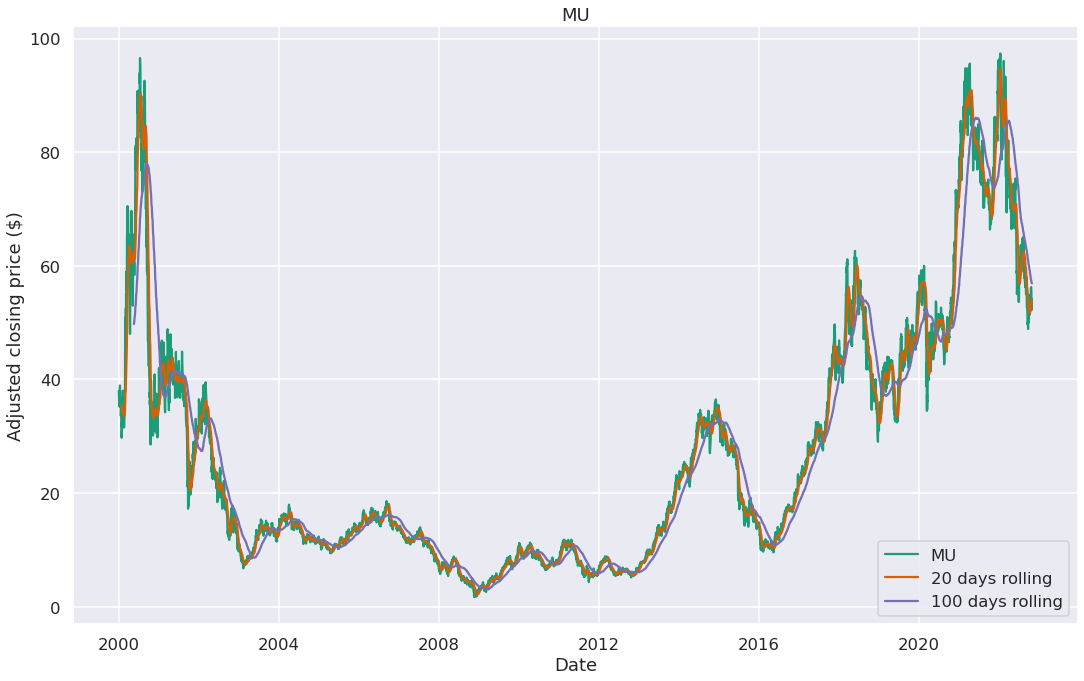

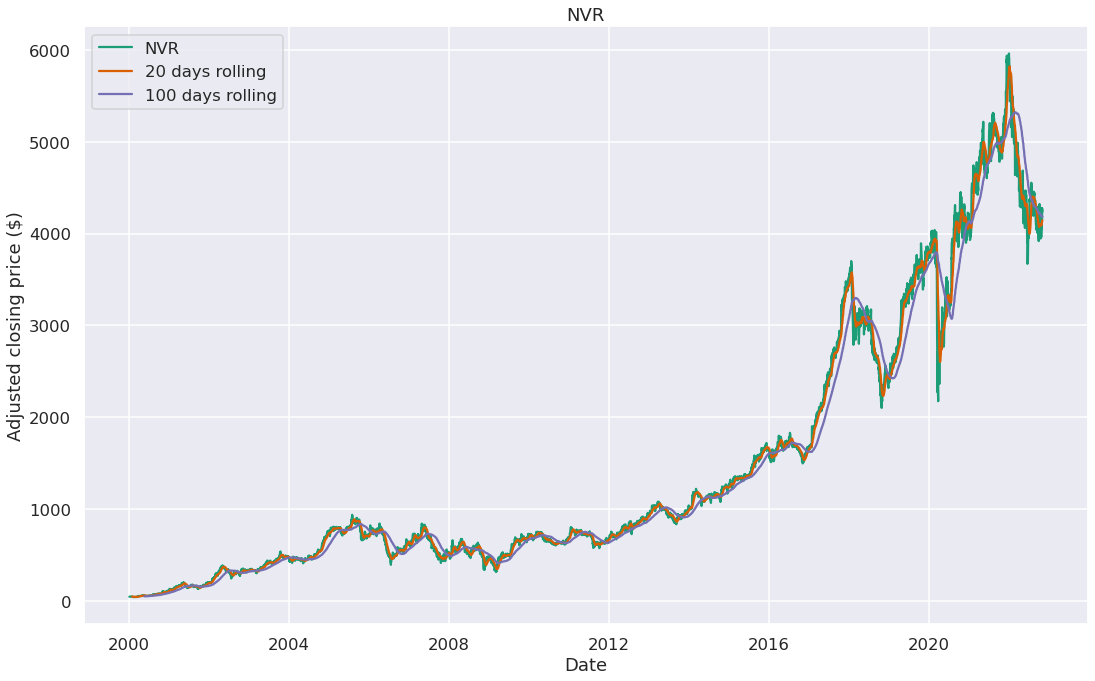

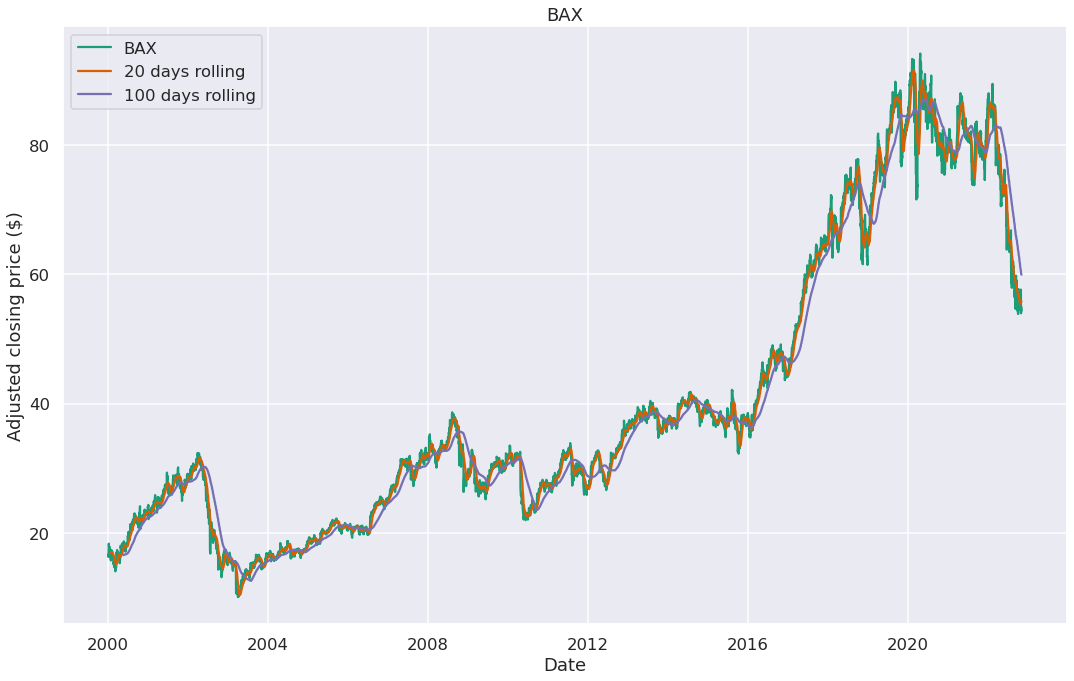

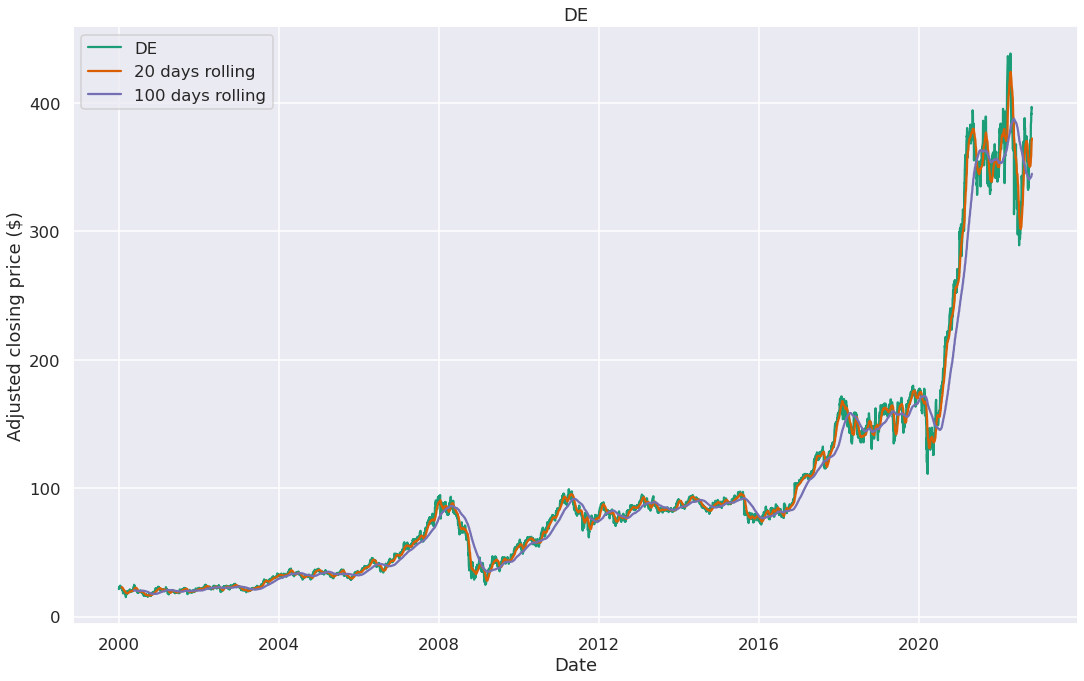

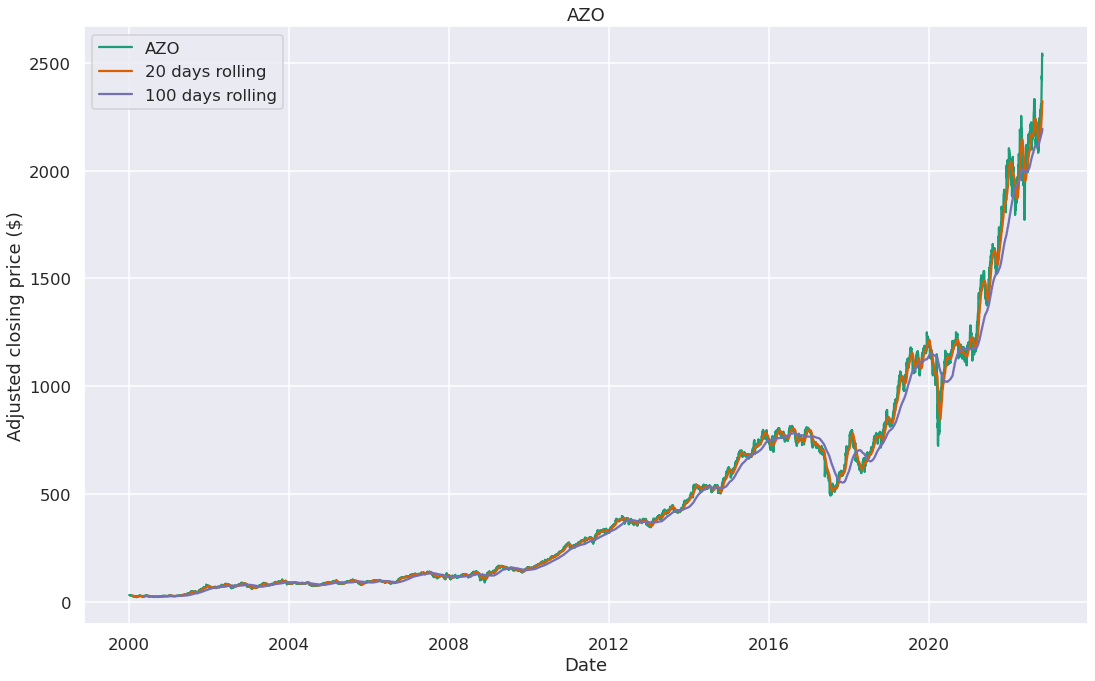

In [147]:
close_print(close[best.columns].columns)

In [148]:
def volume_print(stock_symbol):
    
    df = data.DataReader(stock_symbol, 'yahoo', start_date, end_date)
    volume = df['Volume']
    all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')  # B stands for business day frequency
    volume = volume.reindex(all_weekdays)
    volume = volume.fillna(method='ffill')


    for i in stock_symbol:
        # Get the ticker timeseries. This now returns a Pandas Series object indexed by date.
        ticker = volume.loc[:, i]

        # Calculate the 30 and 100 days moving averages of the closing prices
        short_rolling_ticker = ticker.rolling(window=30).mean()
        long_rolling_ticker = ticker.rolling(window=100).mean()

        # short_rolling_ticker = ticker.rolling(window=30, center=True).mean()
        # long_rolling_ticker = ticker.rolling(window=100, center=True).mean()

        # Plot everything by leveraging the very powerful matplotlib package
        fig, ax = plt.subplots(figsize=(18,11))

        plt.title(i)

        ax.plot(ticker.index, ticker, label=i)
        ax.plot(short_rolling_ticker.index, short_rolling_ticker, label='30 days rolling')
        ax.plot(long_rolling_ticker.index, long_rolling_ticker, label='100 days rolling')

        ax.set_xlabel('Date')
        ax.set_ylabel('Stock Volume')
        ax.legend()

    volume.to_csv("CSV/volume.csv", index=True)


In [149]:
# volume_print(best.columns)

In [150]:
best

,MU,NVR,BAX,DE,AZO
0,16.131248,4191.1875,37.681068,374.382507,2502.317383


In [151]:
close[best.columns]

,MU,NVR,BAX,DE,AZO
2000-01-03,37.968750,46.562500,16.668930,21.437500,30.562500
2000-01-04,36.500000,46.000000,16.295492,21.406250,30.437500
2000-01-05,36.375000,45.875000,17.008419,21.906250,30.312500
2000-01-06,37.000000,45.875000,17.364883,23.031250,29.062500
2000-01-07,35.250000,46.750000,18.349401,23.000000,30.437500
...,...,...,...,...,...
2022-10-25,55.869999,4278.069824,57.110001,391.630005,2439.889893
2022-10-26,55.450001,4185.180176,57.630001,391.179993,2423.679932
2022-10-27,52.209999,4159.520020,53.970001,394.589996,2521.770020
2022-10-28,54.040001,4275.359863,55.000000,396.850006,2543.500000


mean : 26.479646792761667
mean : 1442.8993603070364
mean : 39.99171143461987
mean : 96.98107241239221
mean : 480.91138753481084


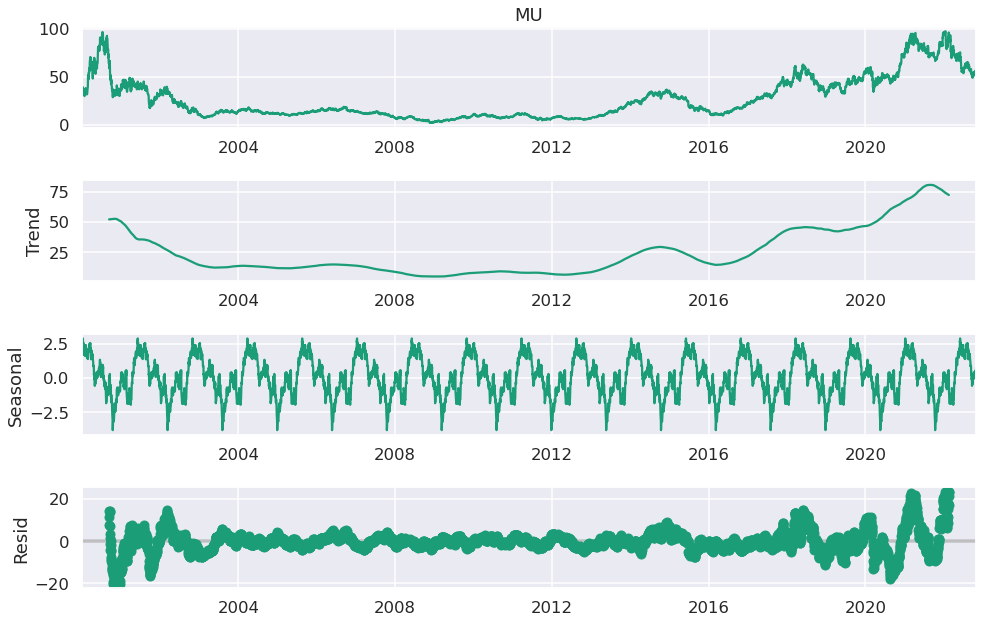

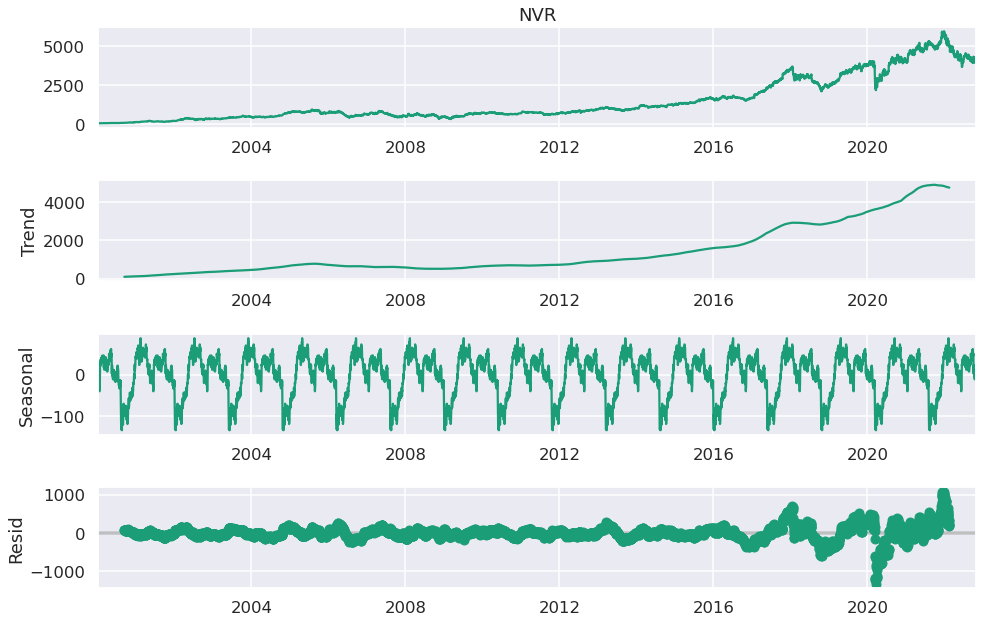

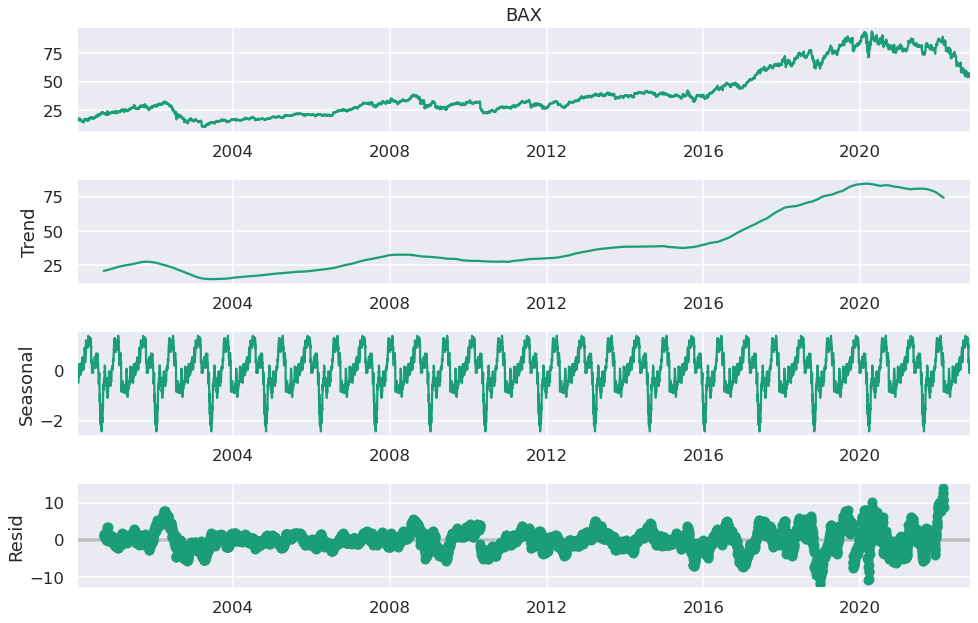

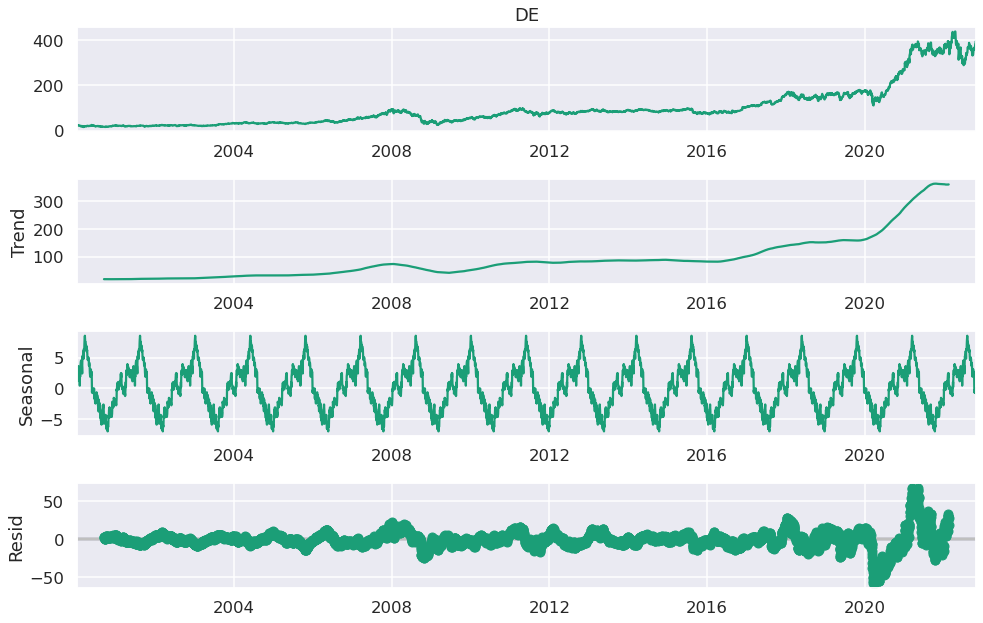

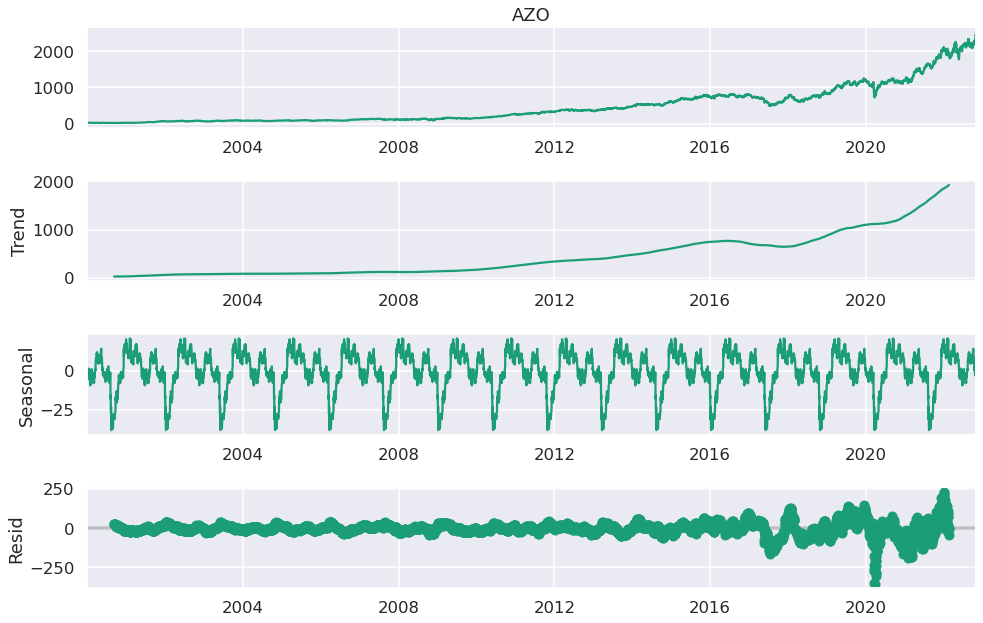

In [152]:
import statsmodels.api as sm
import time

for i in range(len(best.columns)):
    print('mean :' , close[best.columns[i]].mean())
    res = sm.tsa.seasonal_decompose(close[best.columns[i]], period=365 * 1) # Half the total
    resplot = res.plot()
    resplot.set_size_inches((14,9))
    resplot.tight_layout()
    # time.sleep(1) # Sleep for 3 seconds



In [153]:
# import statsmodels.api as sm
# print('mean :' , close['TRV'].mean())
# res = sm.tsa.seasonal_decompose(close['TRV'])
# resplot = res.plot()
# resplot.set_size_inches((14,9))
# resplot.tight_layout()

In [154]:
close[best.columns].columns[0]

'MU'

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


MU


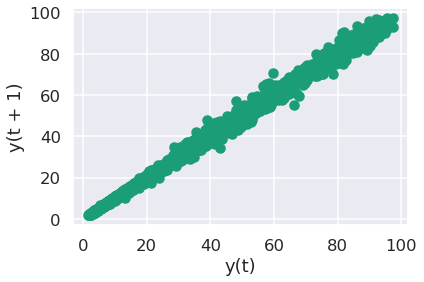

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


NVR


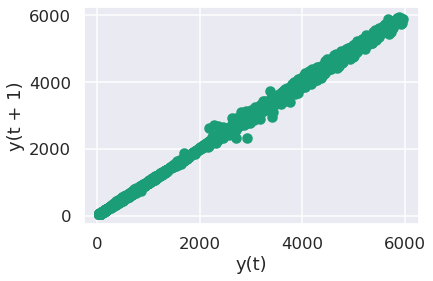

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


BAX


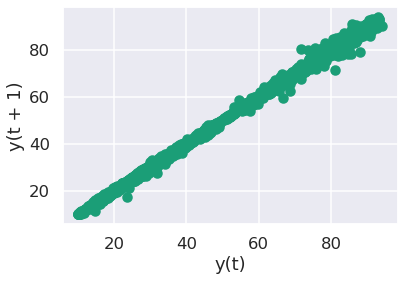

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


DE


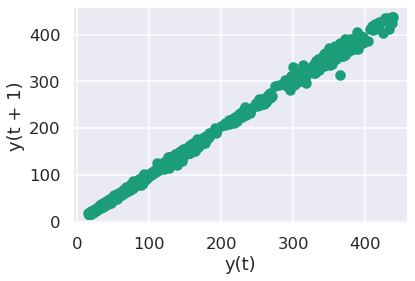

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


AZO


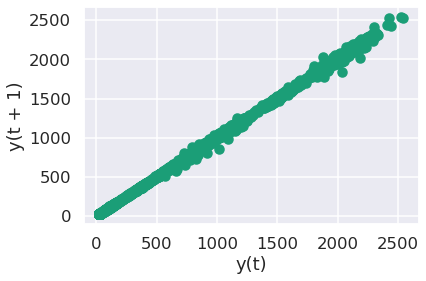

In [155]:
from pandas.plotting import lag_plot
for i in range(len(best.columns)):
    print(close[best.columns].columns[i])
    lag_plot(close[best.columns[i]]).plot
    plt.show()